In [2]:
# Import Pandas and NumPy out of habit
import pandas as pd
import numpy as np

# Append psycopg2's location to the PATH so import knows where to find it
from sys import path
path.append("/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages")
import psycopg2

# Bring in Blaze for talking directly to Hawq
import blaze

# Bring in SQL Alchemy for a cursor
import sqlalchemy as sa

In [175]:
hawqAddress = '192.168.69.142'
hawqUser = 'gpadmin'
hawqDatabase = 'tpch'
hawqTable = "ipyTest"

In [20]:
# Create a conneciton to Hawq
hawq = psycopg2.connect("dbname='{db}' user='{u}' host='{h}'".format(db=hawqDatabase,
                                                                     u=hawqUser,
                                                                     h=hawqAddress))

# Do a basic select on the connection using Pandas
testHawq = pd.read_sql('select * from "{tbl}"'.format(tbl=hawqTable), con=hawq)

In [8]:
# Use SQL Alchemy to create an engine
hawqEngine = sa.create_engine("postgresql://{user}@{host}/{db}".format(user=hawqUser,
                                                                       host=hawqAddress,
                                                                       db=hawqDatabase))
# Connect to the Hawq engine, returning a cursor-like object
hawqCursor = hawqEngine.connect()

In [21]:
# Execute an explain query
res = hawqCursor.execute('explain select * from "{}"'.format(hawqTable))

In [22]:
# Fetch the output
res.fetchall()

# TODO Graphviz Dot: https://github.com/nminoru/pg_plan_tree_dot
# Interactive Dots: http://code.google.com/p/jrfonseca/wiki/XDot

[(u'Gather Motion 1:1  (slice1; segments: 1)  (cost=0.00..1.01 rows=1 width=6)',),
 (u'  ->  Table Scan on "ipyTest"  (cost=0.00..0.01 rows=1 width=6)',)]

In [9]:
# Use the SQL Alchemy engine in Blaze for DataFrame functionality
# see: http://blaze.pydata.org/docs/v_0_6_5/quickstart.html
bd = blaze.Data(hawqEngine)

In [25]:
bd.ipyTest.head(3)

,s,i
0,1,1
1,2,2
2,3,3


In [42]:
"""
for t in retail_demo.categories_dim retail_demo.customers_dim retail_demo.order_lineitems retail_demo.orders retail_demo.customer_addresses_dim retail_demo.date_dim retail_demo.email_addresses_dim retail_demo.payment_methods retail_demo.products_dim; 
> do 
> echo $t
> psql -d retailsales -c "SELECT COUNT(*), gp_segment_id FROM ${t} GROUP BY gp_segment_id;" ; 
> done;
"""
# Use SQL Alchemy to create an engine
hawqDemoEngine = sa.MetaData("postgresql://{user}@{host}/{db}".format(user=hawqUser,
                                                                       host=hawqAddress,
                                                                       db='retailsales'), 
                              schema="retail_demo")
# Use the SQL Alchemy engine in Blaze for DataFrame functionality
# see: http://blaze.pydata.org/docs/v_0_6_5/quickstart.html
blazeDemo = blaze.Data(hawqDemoEngine)

demoTables = ['retail_demo.categories_dim', 
              'retail_demo.customers_dim', 
              'retail_demo.order_lineitems', 
              'retail_demo.orders',
              'retail_demo.customer_addresses_dim',
              'retail_demo.date_dim',
              'retail_demo.email_addresses_dim',
              'retail_demo.payment_methods',
              'retail_demo.products_dim' ]

Blaze does not understand a SQLAlchemy type.
Blaze provided the following error:
	No SQL-datashape match for type BYTEA
Skipping.
Blaze does not understand a SQLAlchemy type.
Blaze provided the following error:
	No SQL-datashape match for type BYTEA
Skipping.


In [50]:
blazeDemo # ['retail_demo.orders'][['gp_segment_id']]

Data:       MetaData(bind=Engine(postgresql://gpadmin@192.168.69.142/retailsales))
DataShape:  {
  retail_demo.categories_dim: var * {category_id: int32, category_name: string},
  retail_demo.customer_addresses_dim: var * {
    customer_address_id: ?string,
    customer_id: ?int32,
    valid_from_timestamp: ?string,
    valid_to_timestamp: ?string,
  ...

# Parse HDFS filesizes to visualize skew

In [313]:
# Use SQL Alchemy to create an engine
hawqEngine = sa.create_engine("postgresql://{user}@{host}".format(user=hawqUser, host=hawqAddress))

# Connect to the Hawq engine, returning a cursor-like object
hawqCursor = hawqEngine.connect()

# Get OID <-> Name mapping for Databases, Tables
databases = hawqCursor.execute('SELECT oid,datname FROM pg_database;').fetchall()
dbLUT = dict(databases)

hawqDemoDb = 'retailsales'
hawqDemoSchema = 'retail_demo'

tableQuery = """SELECT DISTINCT table_name 
FROM information_schema.tables 
WHERE table_catalog = '{t}' 
AND table_schema = '{s}';""".format(t=hawqDemoDb, s=hawqDemoSchema ).replace('\n', '')

# Borrow the hawqEngine from above (it has the schema defined)
hawqDemoCursor = hawqDemoEngine.bind.connect()

demoTableTupleList = hawqDemoCursor.execute(tableQuery).fetchall()
demoTableList = [str(i[0]) for i in demoTableTupleList]

tables = hawqDemoCursor.execute("SELECT oid,relname FROM pg_class where relname in {};"
                                .format(tuple(demoTableList))
                                ).fetchall()
tableLUT = dict(tables)

keys = tableLUT.keys()
for k in keys:
    # Add some entries for table alias ID's found in HDFS
    # and convert the keys into strings
    tableLUT[str(k+0.1)] = tableLUT[k]
    tableLUT[str(k)] = tableLUT[k]
    del tableLUT[k]

Login to the Hawq master and execute a recursive directory listing, capturing the output into a varaible

In [314]:
hdfsFiles = !ssh gpadmin@$hawqAddress -- hdfs dfs -ls -R /hawq_data/

Tokenize each line of output by delimiting on spaces, filter out PG_VERSION metadata files

In [315]:
fieldwise = [f.split() for f in hdfsFiles if 'PG_VERSION' not in f]

In [316]:
# Dictionary used to initialize the Pandas DataFrame for per-table segment groups 
segDict = dict()

# Dictionary used to initialize the Pandas DataFrame for per-segment table groups 
tableDict = dict()

# Parse HDFS directory output, line by line
for l in fieldwise:
    # Extract the byte size field
    bytes = l[-4]
    
    # Ignore directories
    if bytes != '0':
        # The shard is the last field, the entire directory path
        shard = l[-1]
        
        # Split the directory path on slashes
        pathElements = shard.split('/')
        
        # Typical line: /hawq_data/<segment>/ ... /<table>
        
        # Segment is the second field from the beginning of the path
        segment = pathElements[2]
        
        # Table is the last field
        table = pathElements[-1]
        
        # Make the segment => table map
        if segment in segDict:
            segDict[segment][table] = int(bytes)
        else:
            segDict[segment] = dict()
            segDict[segment][table] = int(bytes)
            
        # Make the table => segment map
        if table in tableDict:
            tableDict[table][segment] = int(bytes)
        else:
            tableDict[table] = dict()
            tableDict[table][segment] = int(bytes)

## Look at skew by table

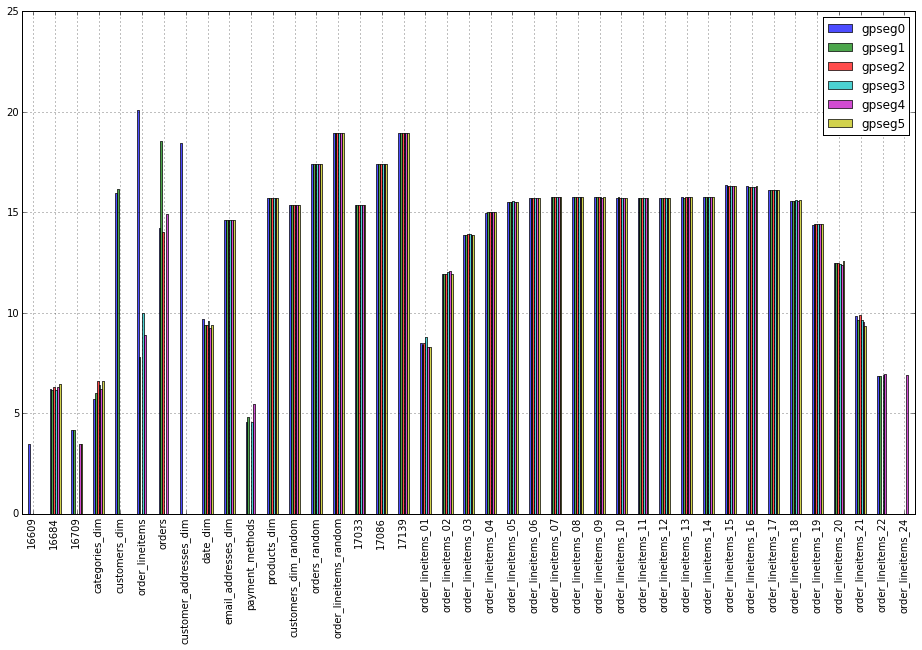

In [319]:
%matplotlib inline

distFrame = pd.DataFrame(segDict)
distFrame.rename_axis(tableLUT, inplace=True)
distFrame.apply(np.log).plot(kind='bar', alpha=0.7, legend=True, figsize=(16,9), rot=90)

## Look at each table's boxplot distribution

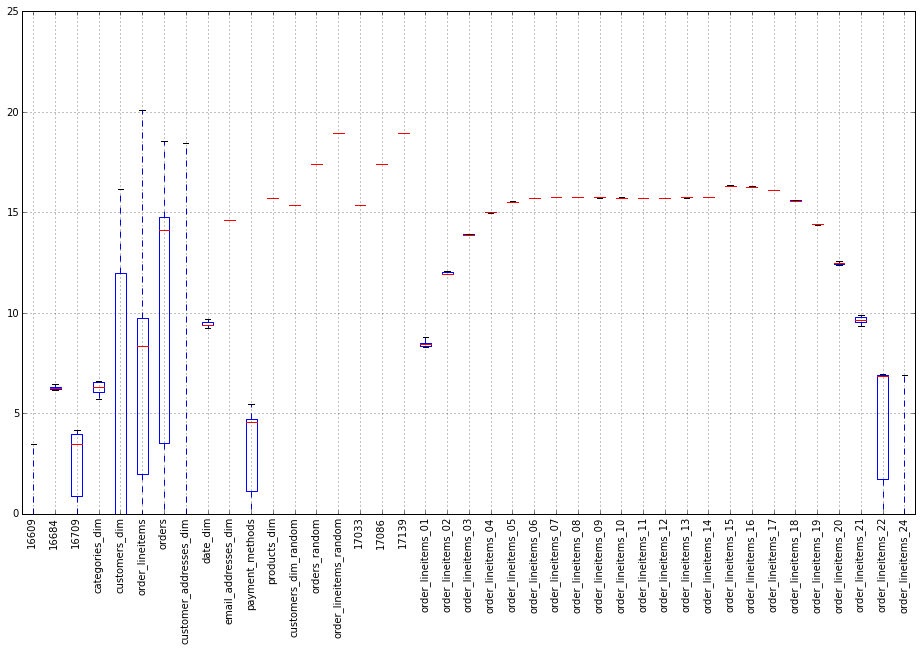

In [320]:
boxFrame = pd.DataFrame(tableDict)
boxFrame.rename_axis(tableLUT, inplace=True, axis=1)
boxFrame.apply(np.log).fillna(0).plot(kind='box', figsize=(16,9), rot=90)

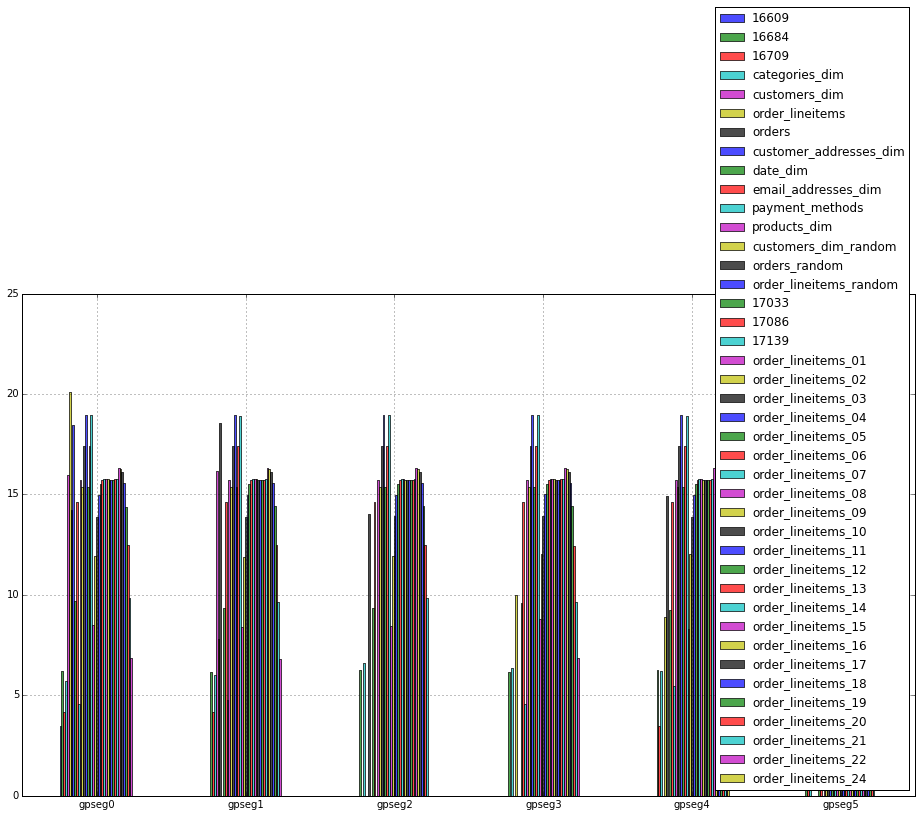

In [321]:
segFrame = pd.DataFrame(tableDict)
segFrame.rename_axis(tableLUT, inplace=True, axis=1)
segFrame.apply(np.log).plot(kind='bar', alpha=0.7, legend=True, figsize=(16,9), rot=0)

In [312]:
tableLUT

{'16724': u'categories_dim',
 '16724.1': u'categories_dim',
 '16729': u'customers_dim',
 '16729.1': u'customers_dim',
 '16734': u'order_lineitems',
 '16734.1': u'order_lineitems',
 '16739': u'orders',
 '16739.1': u'orders',
 '16744': u'customer_addresses_dim',
 '16744.1': u'customer_addresses_dim',
 '16749': u'date_dim',
 '16749.1': u'date_dim',
 '16754': u'email_addresses_dim',
 '16754.1': u'email_addresses_dim',
 '16759': u'payment_methods',
 '16759.1': u'payment_methods',
 '16764': u'products_dim',
 '16764.1': u'products_dim',
 '16786': u'order_lineitems_err',
 '16786.1': u'order_lineitems_err',
 '16808': u'ext_categories_dim',
 '16808.1': u'ext_categories_dim',
 '16810': u'ext_customers_dim',
 '16810.1': u'ext_customers_dim',
 '16812': u'ext_order_lineitems',
 '16812.1': u'ext_order_lineitems',
 '16814': u'ext_orders',
 '16814.1': u'ext_orders',
 '16831': u'ext_customer_addresses_dim',
 '16831.1': u'ext_customer_addresses_dim',
 '16848': u'ext_date_dim',
 '16848.1': u'ext_date_dim'

In [282]:
[str(i[0]) for i in demoTableTupleList]

['ext_order_lineitems',
 'date_dim',
 'ext_products_dim',
 'ext_email_addresses_dim',
 'hdfs_categories_dim_err',
 'categories_dim',
 'hdfs_categories_dim_ext',
 'hdfs_order_lineitems_ext',
 'order_lineitems_err',
 'customer_addresses_dim',
 'ext_customer_addresses_dim',
 'orders',
 'email_addresses_dim',
 'ext_orders',
 'ext_customers_dim',
 'hive_order_lineitems_ext',
 'ext_date_dim',
 'order_lineitems',
 'products_dim',
 'payment_methods',
 'ext_payment_methods',
 'ext_categories_dim',
 'customers_dim',
 'customers_dim_random']